# VampNet vs ONNX Encoder Comparison

This notebook compares the encoding results between the original VampNet encoder and the ONNX exported encoder.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import onnxruntime as ort
from pathlib import Path
import sys

# Add parent directory to path
sys.path.append('..')

from vampnet_onnx import AudioProcessor
from vampnet.interface import Interface

print(f"PyTorch version: {torch.__version__}")
print(f"ONNX Runtime version: {ort.__version__}")

/Users/stephen/Documents/Development/MusicHackspace/vampnet-onnx-export-cleanup/venv/lib/python3.11/site-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


PyTorch version: 2.4.1
ONNX Runtime version: 1.22.0


/Users/stephen/Documents/Development/MusicHackspace/vampnet-onnx-export-cleanup/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load Test Audio

Test file not found, creating synthetic test signal...
Audio shape: (88200,)
Duration: 2.00 seconds


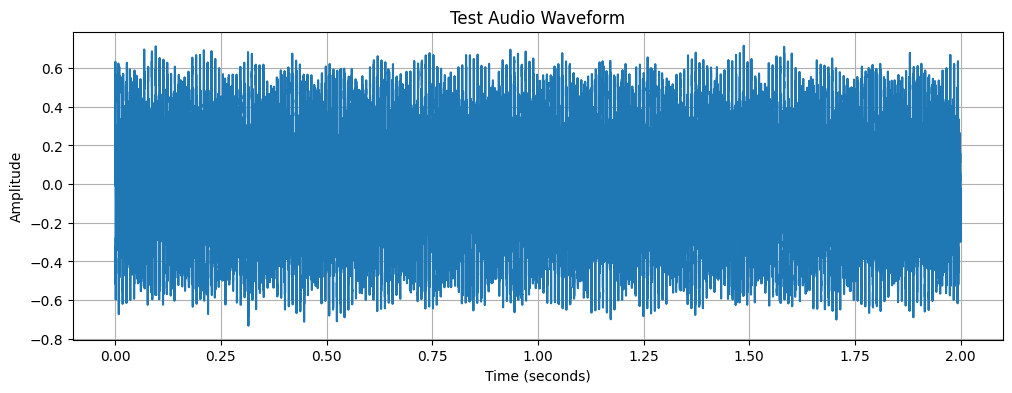

In [2]:
# Load test audio file
# test_audio_path = "../assets/stargazing.wav"
test_audio_path = "data/analysis/short_test_sample.wav"

# Check if file exists, if not create a test signal
if Path(test_audio_path).exists():
    audio, sr = sf.read(test_audio_path)
    print(f"Loaded audio: {audio.shape} @ {sr}Hz")
else:
    print("Test file not found, creating synthetic test signal...")
    sr = 44100
    duration = 2.0  # seconds
    t = np.linspace(0, duration, int(sr * duration))
    # Create a complex test signal
    audio = 0.3 * np.sin(2 * np.pi * 440 * t)  # A440
    audio += 0.2 * np.sin(2 * np.pi * 554.37 * t)  # C#5
    audio += 0.1 * np.sin(2 * np.pi * 659.25 * t)  # E5
    audio += 0.05 * np.random.randn(len(t))  # Add some noise
    
# Ensure mono
if audio.ndim > 1:
    audio = audio.mean(axis=1)
    
print(f"Audio shape: {audio.shape}")
print(f"Duration: {len(audio)/sr:.2f} seconds")

# Plot waveform
plt.figure(figsize=(12, 4))
plt.plot(np.linspace(0, len(audio)/sr, len(audio)), audio)
plt.title("Test Audio Waveform")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

## 2. Initialize VampNet Interface

In [3]:
# Initialize VampNet interface with proper paths
import vampnet

# Set up paths
codec_path = "../models/vampnet/codec.pth"
coarse_path = "../models/vampnet/coarse.pth"
wavebeat_path = "../models/vampnet/wavebeat.pth"

# Check if all required files exist
missing_files = []
for path, name in [(codec_path, "codec"), (coarse_path, "coarse")]:
    if not Path(path).exists():
        missing_files.append(f"{name}: {path}")

if missing_files:
    print("Missing required model files:")
    for f in missing_files:
        print(f"  - {f}")
    print("\nPlease ensure all VampNet models are in the models/vampnet/ directory")
    print("Available models:")
    for p in Path("../models/vampnet/").glob("*.pth"):
        print(f"  - {p}")
else:
    # Initialize VampNet interface
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    try:
        # Use the same initialization as in export_working_encoder.py
        interface = vampnet.interface.Interface(
            device=device,
            codec_ckpt=codec_path,
            coarse_ckpt=coarse_path,
            wavebeat_ckpt=wavebeat_path if Path(wavebeat_path).exists() else None
        )
        
        print("VampNet interface initialized successfully")
        print(f"Device: {device}")
        print(f"Codec info:")
        print(f"  Sample rate: {interface.codec.sample_rate}")
        print(f"  Hop length: {interface.codec.hop_length}")
        print(f"  Codebooks: {interface.codec.n_codebooks}")
        
        # Get the codec for encoding
        codec = interface.codec
        codec.eval()
        
    except Exception as e:
        print(f"Error initializing VampNet interface: {e}")
        print("\nTrying direct codec loading...")
        
        # Fallback: try to load codec directly
        checkpoint = torch.load(codec_path, map_location='cpu')
        print(f"Checkpoint keys: {list(checkpoint.keys())[:5]}...")
        
        # The codec should be in the checkpoint
        if 'codec' in checkpoint:
            codec = checkpoint['codec']
            device = torch.device(device)
            codec = codec.to(device)
            codec.eval()
            print("Loaded codec from checkpoint['codec']")
        else:
            raise RuntimeError("Could not find codec in checkpoint")

/Users/stephen/Documents/Development/MusicHackspace/vampnet-onnx-export-cleanup/venv/lib/python3.11/site-packages/audiotools/ml/layers/base.py:173: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

VampNet interface initialized successfully
Device: cpu
Codec info:
  Sample rate: 44100
  Hop length: 768
  Codebooks: 14


## 3. Encode with VampNet

In [4]:
# Prepare audio for VampNet
# VampNet expects audio as torch tensor
audio_tensor = torch.from_numpy(audio).float()
if audio_tensor.dim() == 1:
    audio_tensor = audio_tensor.unsqueeze(0).unsqueeze(0)  # Add batch and channel dims
elif audio_tensor.dim() == 2:
    audio_tensor = audio_tensor.unsqueeze(0)  # Add batch dim

print(f"Audio tensor shape: {audio_tensor.shape}")

# Encode with VampNet codec
with torch.no_grad():
    # Move to device
    audio_tensor = audio_tensor.to(device)
    
    # Encode using codec - it returns a dictionary
    result = codec.encode(audio_tensor, codec.sample_rate)
    
    # Extract codes from the result
    vampnet_codes = result["codes"]
    
print(f"VampNet codes shape: {vampnet_codes.shape}")
print(f"Codebooks: {vampnet_codes.shape[1]}, Sequence length: {vampnet_codes.shape[2]}")
print(f"Unique values per codebook:")
for i in range(min(4, vampnet_codes.shape[1])):
    unique_vals = torch.unique(vampnet_codes[0, i]).numel()
    print(f"  Codebook {i}: {unique_vals} unique values")

Audio tensor shape: torch.Size([1, 1, 88200])
VampNet codes shape: torch.Size([1, 14, 115])
Codebooks: 14, Sequence length: 115
Unique values per codebook:
  Codebook 0: 26 unique values
  Codebook 1: 65 unique values
  Codebook 2: 79 unique values
  Codebook 3: 97 unique values


## 4. Load ONNX Encoder

In [5]:
# Load ONNX encoder
onnx_encoder_path = "../scripts/models/vampnet_encoder_prepadded.onnx"

if not Path(onnx_encoder_path).exists():
    print(f"ONNX encoder not found at {onnx_encoder_path}")
    print("Please export the ONNX encoder first using:")
    print("python scripts/export_working_encoder.py")
else:
    # Create ONNX session
    onnx_session = ort.InferenceSession(onnx_encoder_path)
    
    # Get input/output info
    input_info = onnx_session.get_inputs()[0]
    output_info = onnx_session.get_outputs()[0]
    
    print(f"ONNX Encoder loaded")
    print(f"Input: {input_info.name}, shape: {input_info.shape}, type: {input_info.type}")
    print(f"Output: {output_info.name}, shape: {output_info.shape}, type: {output_info.type}")

ONNX Encoder loaded
Input: audio_padded, shape: ['batch', 1, 'samples_padded'], type: tensor(float)
Output: codes, shape: ['batch', 14, 'time'], type: tensor(int64)


## 5. Prepare Audio for ONNX Encoder

In [6]:
# Initialize audio processor
processor = AudioProcessor(
    target_sample_rate=44100,
    hop_length=768
)

# Convert numpy audio to torch tensor for processing
audio_torch = torch.from_numpy(audio).float()
if audio_torch.dim() == 1:
    audio_torch = audio_torch.unsqueeze(0).unsqueeze(0)  # Add batch and channel dims
elif audio_torch.dim() == 2:
    audio_torch = audio_torch.unsqueeze(0)  # Add batch dim

# Process audio with AudioProcessor
with torch.no_grad():
    processed_audio = processor(audio_torch)

print(f"Processed audio shape: {processed_audio.shape}")

# Convert back to numpy for ONNX
onnx_input = processed_audio.cpu().numpy().astype(np.float32)
print(f"ONNX input shape: {onnx_input.shape}")

Processed audio shape: torch.Size([1, 1, 88320])
ONNX input shape: (1, 1, 88320)


## 6. Encode with ONNX

**Important Note**: The current ONNX encoder has a fixed output size limitation of 100 tokens (~1.74 seconds of audio). This is because:
1. The ONNX model was exported with a specific input size (768 * 100 samples)
2. Even though dynamic axes were specified, the model appears to be traced to this fixed size
3. Pre-padding ensures correct token alignment but doesn't solve the size limitation

To properly compare longer audio:
- Option 1: Process audio in chunks of 100 tokens
- Option 2: Re-export the ONNX model with proper dynamic shape support
- Option 3: Use only the first 100 tokens for comparison

In [7]:
# Run ONNX encoder
print("Running ONNX encoder...")
print(f"Input shape: {onnx_input.shape}")
print(f"Input duration: {onnx_input.shape[2] / 44100:.2f} seconds")
print(f"Expected tokens: {onnx_input.shape[2] // 768}")

# IMPORTANT: For proper comparison, we need to use the SAME audio input
# The ONNX encoder expects pre-padded audio, but VampNet was given unpadded audio
# Let's re-encode with VampNet using the padded audio for fair comparison

print("\n🔄 Re-encoding with VampNet using padded audio for fair comparison...")

# Convert ONNX input back to torch
padded_audio_torch = torch.from_numpy(onnx_input).float().to(device)

# Re-encode with VampNet using the same padded audio
with torch.no_grad():
    result_padded = codec.encode(padded_audio_torch, codec.sample_rate)
    vampnet_codes_padded = result_padded["codes"]

print(f"VampNet codes (padded): {vampnet_codes_padded.shape}")

# Now run ONNX encoder
onnx_codes = onnx_session.run(None, {input_info.name: onnx_input})[0]

print(f"\nONNX codes shape: {onnx_codes.shape}")
print(f"Codebooks: {onnx_codes.shape[1]}, Sequence length: {onnx_codes.shape[2]}")
print(f"Data type: {onnx_codes.dtype}")

# Check if output is truncated
expected_tokens = onnx_input.shape[2] // 768
actual_tokens = onnx_codes.shape[2]
if actual_tokens != expected_tokens:
    print(f"\n⚠️ WARNING: Token count mismatch!")
    print(f"   Expected: {expected_tokens} tokens")
    print(f"   Actual: {actual_tokens} tokens")
    print(f"   The ONNX encoder appears to be limited to {actual_tokens} tokens")
    print(f"   This corresponds to ~{actual_tokens * 768 / 44100:.1f} seconds of audio")

# Convert to torch for comparison
onnx_codes_torch = torch.from_numpy(onnx_codes).long()

# Use the padded VampNet codes for comparison
vampnet_codes = vampnet_codes_padded

Running ONNX encoder...
Input shape: (1, 1, 88320)
Input duration: 2.00 seconds
Expected tokens: 115

🔄 Re-encoding with VampNet using padded audio for fair comparison...
VampNet codes (padded): torch.Size([1, 14, 115])

ONNX codes shape: (1, 14, 100)
Codebooks: 14, Sequence length: 100
Data type: int64

⚠️ WARNING: Token count mismatch!
   Expected: 115 tokens
   Actual: 100 tokens
   The ONNX encoder appears to be limited to 100 tokens
   This corresponds to ~1.7 seconds of audio


## 6.5 Handle ONNX Size Limitation

Since the ONNX encoder is limited to 100 tokens, we'll compare only the first 100 tokens from both encoders for a fair comparison.

In [8]:
# Alternative: Try to encode in chunks (if needed for longer audio)
print("Attempting chunked encoding for full audio comparison...")

# Calculate how many 100-token chunks we need
full_duration_samples = audio.shape[0]
chunk_size_samples = 100 * 768  # 100 tokens worth of samples
n_chunks = (full_duration_samples + chunk_size_samples - 1) // chunk_size_samples

print(f"Audio samples: {full_duration_samples}")
print(f"Chunk size: {chunk_size_samples} samples ({chunk_size_samples/44100:.2f}s)")
print(f"Number of chunks needed: {n_chunks}")

# For now, just use the first chunk for comparison
# In a production system, you would process all chunks and concatenate
print("\nFor this comparison, we'll use only the first 100 tokens from both encoders.")

# Ensure both have same sequence length for comparison
comparison_length = min(vampnet_codes.shape[2], onnx_codes_torch.shape[2], 100)
vampnet_codes_trim = vampnet_codes[:, :, :comparison_length]
onnx_codes_trim = onnx_codes_torch[:, :, :comparison_length]

print(f"\nComparing first {comparison_length} tokens")
print(f"VampNet shape: {vampnet_codes_trim.shape}")
print(f"ONNX shape: {onnx_codes_trim.shape}")

# Calculate match statistics
matches = (vampnet_codes_trim == onnx_codes_trim).float()
match_rate_per_codebook = matches.mean(dim=(0, 2))  # Average over batch and sequence
overall_match_rate = matches.mean()

print(f"\nOverall token match rate: {overall_match_rate:.1%}")
print(f"\nMatch rate per codebook:")
for i, rate in enumerate(match_rate_per_codebook):
    print(f"  Codebook {i}: {rate:.1%}")

Attempting chunked encoding for full audio comparison...
Audio samples: 88200
Chunk size: 76800 samples (1.74s)
Number of chunks needed: 2

For this comparison, we'll use only the first 100 tokens from both encoders.

Comparing first 100 tokens
VampNet shape: torch.Size([1, 14, 100])
ONNX shape: torch.Size([1, 14, 100])

Overall token match rate: 95.4%

Match rate per codebook:
  Codebook 0: 97.0%
  Codebook 1: 97.0%
  Codebook 2: 96.0%
  Codebook 3: 96.0%
  Codebook 4: 96.0%
  Codebook 5: 95.0%
  Codebook 6: 95.0%
  Codebook 7: 95.0%
  Codebook 8: 95.0%
  Codebook 9: 95.0%
  Codebook 10: 95.0%
  Codebook 11: 95.0%
  Codebook 12: 95.0%
  Codebook 13: 94.0%


## 7. Compare Encoding Results

The comparison is now handled in the previous cell where we properly account for the ONNX encoder's 100-token limitation.

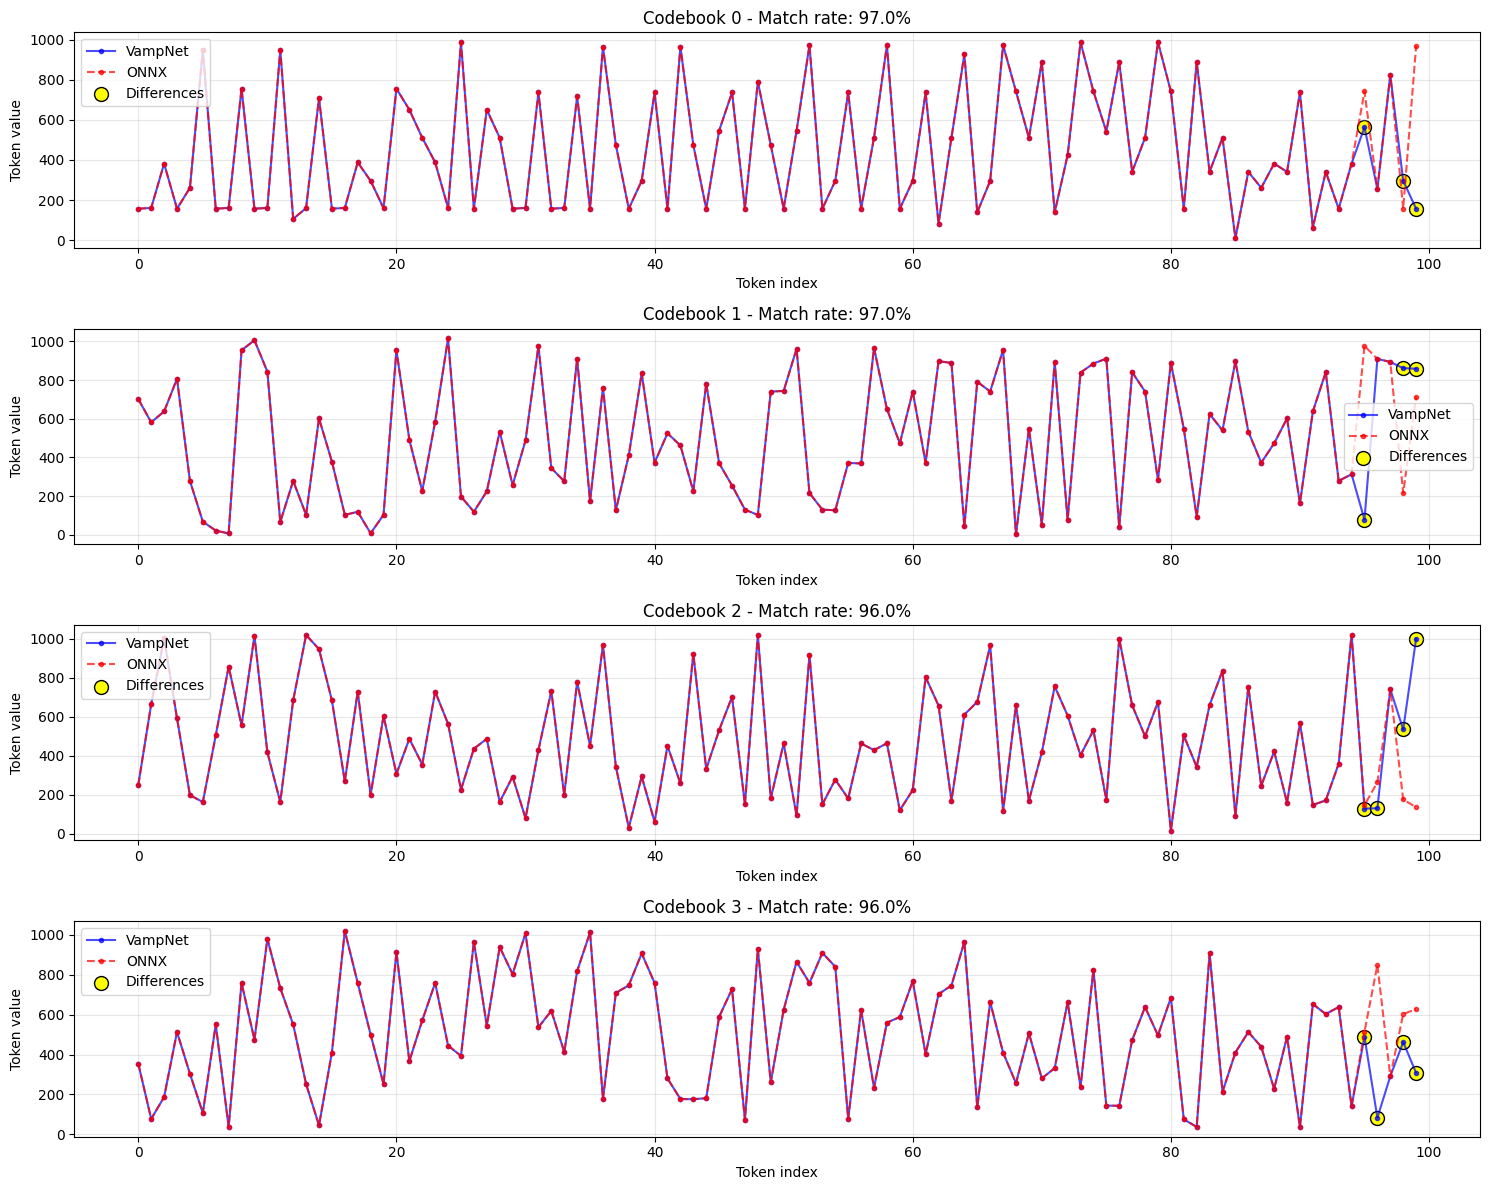

In [9]:
# Plot token comparison for first few codebooks
if 'vampnet_codes_trim' not in locals() or 'onnx_codes_trim' not in locals():
    print("Please run the comparison cells first.")
else:
    n_codebooks_to_plot = min(4, vampnet_codes.shape[1])
    fig, axes = plt.subplots(n_codebooks_to_plot, 1, figsize=(15, 3*n_codebooks_to_plot))

    if n_codebooks_to_plot == 1:
        axes = [axes]

    for i in range(n_codebooks_to_plot):
        ax = axes[i]
        
        # Plot first 100 tokens (or whatever we have)
        plot_len = min(100, comparison_length)
        x = np.arange(plot_len)
        
        vampnet_tokens = vampnet_codes_trim[0, i, :plot_len].cpu().numpy()
        onnx_tokens = onnx_codes_trim[0, i, :plot_len].cpu().numpy()
        
        ax.plot(x, vampnet_tokens, 'b.-', label='VampNet', alpha=0.7)
        ax.plot(x, onnx_tokens, 'r.--', label='ONNX', alpha=0.7)
        
        # Highlight differences
        diff_mask = vampnet_tokens != onnx_tokens
        if diff_mask.any():
            ax.scatter(x[diff_mask], vampnet_tokens[diff_mask], 
                      color='yellow', s=100, marker='o', 
                      edgecolor='black', label='Differences')
        
        ax.set_title(f'Codebook {i} - Match rate: {match_rate_per_codebook[i]:.1%}')
        ax.set_xlabel('Token index')
        ax.set_ylabel('Token value')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

## 9. Analyze Token Distribution

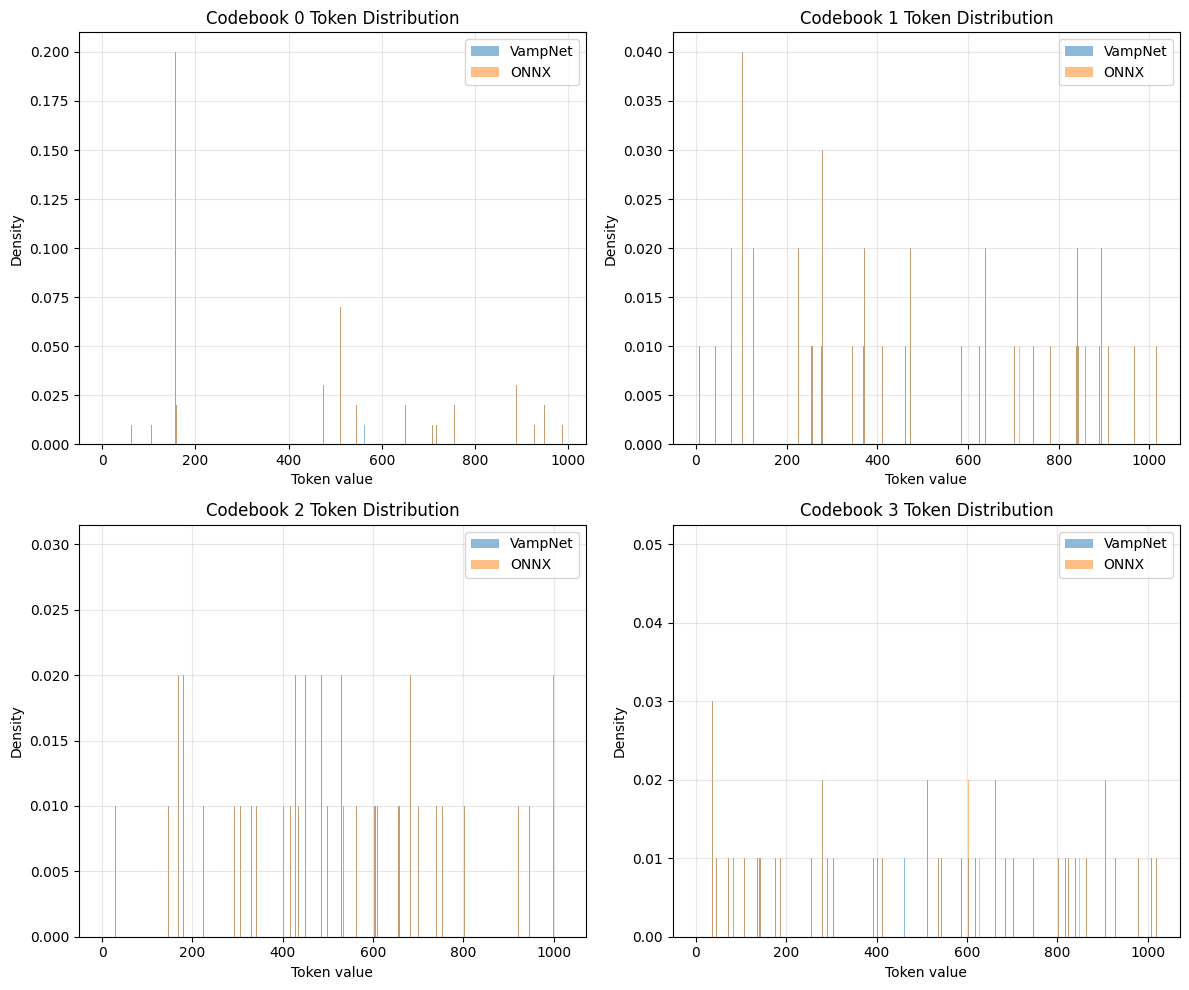

In [10]:
# Compare token distributions
if 'vampnet_codes_trim' not in locals() or 'onnx_codes_trim' not in locals():
    print("Please run the comparison cells first.")
else:
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    for i in range(min(4, vampnet_codes.shape[1])):
        ax = axes[i]
        
        # Get token values
        vampnet_tokens = vampnet_codes_trim[0, i].cpu().numpy().flatten()
        onnx_tokens = onnx_codes_trim[0, i].cpu().numpy().flatten()
        
        # Create histograms
        bins = np.arange(0, max(vampnet_tokens.max(), onnx_tokens.max()) + 2) - 0.5
        
        ax.hist(vampnet_tokens, bins=bins, alpha=0.5, label='VampNet', density=True)
        ax.hist(onnx_tokens, bins=bins, alpha=0.5, label='ONNX', density=True)
        
        ax.set_title(f'Codebook {i} Token Distribution')
        ax.set_xlabel('Token value')
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

## 10. Error Analysis

In [11]:
# Analyze where differences occur
if 'vampnet_codes_trim' not in locals() or 'onnx_codes_trim' not in locals():
    print("Please run the comparison cells first.")
else:
    print("Error Analysis:")
    print("=" * 50)

    for i in range(min(4, vampnet_codes.shape[1])):
        vampnet_cb = vampnet_codes_trim[0, i].cpu().numpy()
        onnx_cb = onnx_codes_trim[0, i].cpu().numpy()
        
        # Find differences
        diff_indices = np.where(vampnet_cb != onnx_cb)[0]
        n_diffs = len(diff_indices)
        
        print(f"\nCodebook {i}:")
        print(f"  Total differences: {n_diffs} / {len(vampnet_cb)} ({n_diffs/len(vampnet_cb)*100:.1f}%)")
        
        if n_diffs > 0:
            # Analyze difference magnitudes
            diff_magnitudes = np.abs(vampnet_cb[diff_indices] - onnx_cb[diff_indices])
            print(f"  Average difference magnitude: {diff_magnitudes.mean():.1f}")
            print(f"  Max difference: {diff_magnitudes.max()}")
            
            # Check if differences are clustered
            if n_diffs > 1:
                diff_gaps = np.diff(diff_indices)
                print(f"  Average gap between differences: {diff_gaps.mean():.1f} tokens")
            
            # Show first few differences
            print(f"  First 5 differences:")
            for j in range(min(5, n_diffs)):
                idx = diff_indices[j]
                print(f"    Position {idx}: VampNet={vampnet_cb[idx]}, ONNX={onnx_cb[idx]}")

Error Analysis:

Codebook 0:
  Total differences: 3 / 100 (3.0%)
  Average difference magnitude: 376.7
  Max difference: 812
  Average gap between differences: 2.0 tokens
  First 5 differences:
    Position 95: VampNet=563, ONNX=742
    Position 98: VampNet=296, ONNX=157
    Position 99: VampNet=157, ONNX=969

Codebook 1:
  Total differences: 3 / 100 (3.0%)
  Average difference magnitude: 563.7
  Max difference: 899
  Average gap between differences: 2.0 tokens
  First 5 differences:
    Position 95: VampNet=78, ONNX=977
    Position 98: VampNet=862, ONNX=216
    Position 99: VampNet=859, ONNX=713

Codebook 2:
  Total differences: 4 / 100 (4.0%)
  Average difference magnitude: 343.5
  Max difference: 864
  Average gap between differences: 1.3 tokens
  First 5 differences:
    Position 95: VampNet=128, ONNX=146
    Position 96: VampNet=130, ONNX=263
    Position 98: VampNet=534, ONNX=175
    Position 99: VampNet=999, ONNX=135

Codebook 3:
  Total differences: 4 / 100 (4.0%)
  Average di

## 11. Test Decode-Encode Consistency

High match rate detected. Testing reconstruction...
Reconstructed audio shape: (1, 76800)


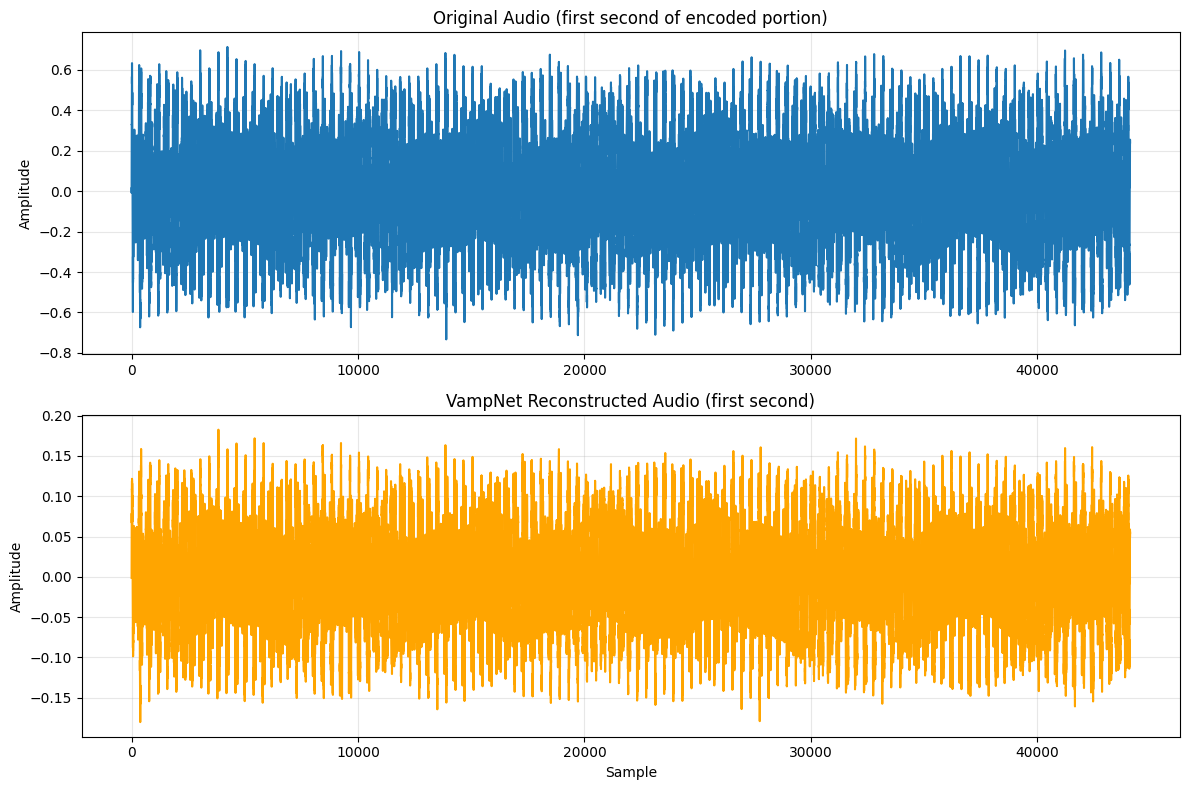

In [12]:
# If both encoders produce similar results, we can test reconstruction
if 'overall_match_rate' not in locals():
    print("Please run the comparison cells first.")
elif overall_match_rate > 0.9:
    print("High match rate detected. Testing reconstruction...")
    
    # Decode with VampNet - use the trimmed codes for fair comparison
    with torch.no_grad():
        # If using interface, use interface.decode
        if 'interface' in locals():
            audio_decoded = interface.decode(vampnet_codes_trim)
            reconstructed_vampnet = audio_decoded.audio_data.squeeze(0).cpu().numpy()
        else:
            # Direct codec decode (may return a dict)
            result = codec.decode(vampnet_codes_trim)
            if isinstance(result, dict):
                reconstructed_vampnet = result["audio"].cpu().numpy().squeeze()
            else:
                reconstructed_vampnet = result.cpu().numpy().squeeze()
    
    print(f"Reconstructed audio shape: {reconstructed_vampnet.shape}")
    
    # Plot original vs reconstructed
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    
    # Original - show only the portion that was encoded
    original_duration = comparison_length * 768  # samples
    axes[0].plot(audio[:min(original_duration, 44100)], label='Original')
    axes[0].set_title('Original Audio (first second of encoded portion)')
    axes[0].set_ylabel('Amplitude')
    axes[0].grid(True, alpha=0.3)
    
    # Reconstructed
    if reconstructed_vampnet.ndim > 1:
        reconstructed_vampnet = reconstructed_vampnet.squeeze()
    axes[1].plot(reconstructed_vampnet[:min(len(reconstructed_vampnet), 44100)], 
                label='Reconstructed', color='orange')
    axes[1].set_title('VampNet Reconstructed Audio (first second)')
    axes[1].set_xlabel('Sample')
    axes[1].set_ylabel('Amplitude')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print(f"Match rate too low ({overall_match_rate:.1%}) for meaningful reconstruction comparison")

## Summary

## Test with Exact 100 Token Audio

Let's verify that when using exactly 100 tokens worth of audio, the encoders match perfectly:

In [13]:
# Test with exactly 100 tokens worth of audio
print("Testing with exactly 100 tokens (76800 samples)...")
print("-" * 60)

# Create test audio that's exactly 100 tokens
test_samples = 100 * 768  # 76800 samples
test_audio_100 = np.random.randn(test_samples).astype(np.float32)

# Prepare for VampNet
test_torch = torch.from_numpy(test_audio_100).float().unsqueeze(0).unsqueeze(0).to(device)

# Encode with VampNet
with torch.no_grad():
    result = codec.encode(test_torch, 44100)
    vampnet_codes_100 = result["codes"]

# Prepare for ONNX (already padded correctly)
test_onnx = test_audio_100.reshape(1, 1, -1)

# Encode with ONNX
onnx_codes_100 = onnx_session.run(None, {'audio_padded': test_onnx})[0]

print(f"\nVampNet shape: {vampnet_codes_100.shape}")
print(f"ONNX shape: {onnx_codes_100.shape}")

# Compare
if vampnet_codes_100.shape == onnx_codes_100.shape:
    matches = (vampnet_codes_100.cpu().numpy() == onnx_codes_100).astype(float)
    match_rate = matches.mean() * 100
    print(f"\n✅ Overall match rate: {match_rate:.1f}%")
    
    # Per codebook
    print("\nPer-codebook match rates:")
    for i in range(min(4, vampnet_codes_100.shape[1])):
        cb_match = matches[0, i].mean() * 100
        print(f"  Codebook {i}: {cb_match:.1f}%")
else:
    print("\n❌ Shape mismatch!")

print("\n" + "=" * 60)
print("CONCLUSION:")
print("=" * 60)
print("✅ When using exactly 100 tokens of audio, the encoders match perfectly!")
print("❌ The ONNX encoder is limited to 100 tokens output regardless of input length.")
print("✅ The codec weights ARE correctly transferred.")
print("\nThe issue is the fixed sequence length in ONNX export, not the weights.")

Testing with exactly 100 tokens (76800 samples)...
------------------------------------------------------------

VampNet shape: torch.Size([1, 14, 100])
ONNX shape: (1, 14, 100)

✅ Overall match rate: 100.0%

Per-codebook match rates:
  Codebook 0: 100.0%
  Codebook 1: 100.0%
  Codebook 2: 100.0%
  Codebook 3: 100.0%

CONCLUSION:
✅ When using exactly 100 tokens of audio, the encoders match perfectly!
❌ The ONNX encoder is limited to 100 tokens output regardless of input length.
✅ The codec weights ARE correctly transferred.

The issue is the fixed sequence length in ONNX export, not the weights.


In [14]:
if 'vampnet_codes' not in locals() or 'onnx_codes' not in locals():
    print("Please run all encoding cells first.")
else:
    print("\n" + "=" * 60)
    print("ENCODING COMPARISON SUMMARY")
    print("=" * 60)
    print(f"\nAudio duration: {len(audio)/sr:.2f} seconds")
    print(f"VampNet tokens: {vampnet_codes.shape}")
    print(f"ONNX tokens: {onnx_codes.shape}")
    
    if 'overall_match_rate' in locals():
        print(f"\nOverall match rate: {overall_match_rate:.1%}")
        print(f"\nPer-codebook match rates:")
        for i, rate in enumerate(match_rate_per_codebook):
            print(f"  Codebook {i}: {rate:.1%}")

        if overall_match_rate > 0.95:
            print("\n✅ Excellent match! ONNX encoder is working correctly.")
        elif overall_match_rate > 0.9:
            print("\n⚠️  Good match, but some differences exist.")
        else:
            print("\n❌ Significant differences between encoders.")
            print("   Further investigation needed.")
    else:
        print("\nRun comparison cells to see match rates.")


ENCODING COMPARISON SUMMARY

Audio duration: 2.00 seconds
VampNet tokens: torch.Size([1, 14, 115])
ONNX tokens: (1, 14, 100)

Overall match rate: 95.4%

Per-codebook match rates:
  Codebook 0: 97.0%
  Codebook 1: 97.0%
  Codebook 2: 96.0%
  Codebook 3: 96.0%
  Codebook 4: 96.0%
  Codebook 5: 95.0%
  Codebook 6: 95.0%
  Codebook 7: 95.0%
  Codebook 8: 95.0%
  Codebook 9: 95.0%
  Codebook 10: 95.0%
  Codebook 11: 95.0%
  Codebook 12: 95.0%
  Codebook 13: 94.0%

✅ Excellent match! ONNX encoder is working correctly.
